# Analysis of Medicare claims — "suicidal ideation" and River Point lengths of stay

For details on the methodology and context, please [read here](https://github.com/BuzzFeedNews/2016-12-suicidal-ideation-coding).

The notebook is divided into three sections:

- __Data processing__
- __Suicidal ideation analysis__
- __River Point analysis__

---

# Data processing

### Load Medicare claim data

BuzzFeed News obtained, through a data-sharing agreement with [ProPublica](https://propublica.org), Medicare claim data from the Centers for Medicare & Medicaid Services for the years 2009–2013. Specifically, we used Medicare’s Limited Data Set files. Due to the sensitivity of these files, CMS prohibits users from republishing the raw data, any patient-identifying information, or any aggregate statistics that refer to 10 or fewer people. We've restructured the files slightly, but a good general overviews of the fields and definitions is [here](https://www.cms.gov/Research-Statistics-Data-and-Systems/Files-for-Order/LimitedDataSets/Downloads/InpatientVersionJ2011.pdf) `(2011–present)` and [here](https://www.cms.gov/Research-Statistics-Data-and-Systems/Files-for-Order/LimitedDataSets/Downloads/SAFldsINP_DD_Pre2011.pdf) `(pre-2011)`.

The main fields we're using:

- `PROVIDER`: The hospital's CMS Certification Number
- `DSYSRTKY`: A unique, numeric identifier assigned to each Medicare beneficiary
- `ADMSN_DT`: The date of admission
- `DSCHRGDT`: The date of discharge
- `DRG_CD`: Classification under Medicare's “Diagnosis Related Group” system
- `DGNSCD{1,2,...}`: Specific diagnoses codes

In [1]:
import pandas as pd
import seaborn as sb
import datetime
%matplotlib inline

In [2]:
MEDICARE_BASE_PATH = "~/local-only/medicare-data/restructured/fsph-claims/"

In [3]:
claims = pd.read_csv(
    MEDICARE_BASE_PATH + "claim.csv",
    dtype={
        "PROVIDER": str,
        "DSCHRGDT": str,
        "ADMSN_DT": str,
        "DRG_CD": str,
        "DSYSRTKY": str 
    },
    na_values=[ "00000000" ])\
    .sort_values([ "ADMSN_DT", "CLAIM_NO"])

In [4]:
claims["admission_dt"] = pd.to_datetime(claims["ADMSN_DT"], format="%Y%m%d")
claims["discharge_dt"] = pd.to_datetime(claims["DSCHRGDT"], format="%Y%m%d")

Total claims:

In [5]:
len(claims)

867070

Provider count:

In [6]:
claims["PROVIDER"].nunique()

550

### Identify stays

A provider can file multiple claims for a single hospital stay. BuzzFeed News identified claims belonging to a common stay by comparing the patient’s numeric identifier, the patient’s admission date, and the provider’s CMS Certification Number. BuzzFeed News identified 822,749 such stays in the data, including 812,350 with a discharge date. (The Medicare dataset also includes claims for patients who, at the time of data submission, had not yet been discharged.)

In [7]:
claims["stay_uid"] = claims[[ "PROVIDER", "DSYSRTKY", "ADMSN_DT" ]].apply("|".join, axis=1)

In [8]:
claims["stay_uid"].nunique()

822749

In [9]:
stays = claims.reset_index().sort_values([ "stay_uid", "CLAIM_NO", "discharge_dt" ])\
    .groupby("stay_uid")[[
        "PROVIDER", "DRG_CD", "admission_dt", "discharge_dt", "ID"
    ]].last().rename(columns={"ID": "last_claim_id"})

In [10]:
discharges = stays[stays["discharge_dt"].notnull()].copy()

In [11]:
len(discharges)

812350

### Load diagnoses

This data also comes from the Medicare claims dataset, but has been split into its own file by BuzzFeed News, for ease of anaylysis.

In [12]:
diagnoses = pd.read_csv(
    MEDICARE_BASE_PATH + "dgnscd.csv",
    dtype={ "value": str }
)

In [13]:
diagnoses["stay_uid"] = pd.merge(
    diagnoses,
    stays.reset_index()[[ "stay_uid", "last_claim_id" ]],
    right_on="last_claim_id",
    left_on="main_claim_id",
    how="left"
)["stay_uid"]

### Identify whether stay includes `V6284` diagnosis code

ICD-9 code V6284 indicates a diagnosis of “suicidal ideation.” BuzzFeed News identified which claims included a V6284 diagnosis.

In [14]:
discharges["diagnoses_incl_si"] = discharges.index.isin(diagnoses[diagnoses["value"] == "V6284"]["stay_uid"])

In [15]:
discharges["diagnoses_incl_si_10"] = discharges.index.isin(diagnoses[
    (diagnoses["value"] == "V6284") &
    (diagnoses["SGMT_NUM"] == 1) &
    (diagnoses["num"] <= 10)
]["stay_uid"])

### Connect stays to hospital names and ownership

The American Hospital Directory classifies all hospitals into three broad categories of ownership: government, proprietary/for-profit, and nonprofit. BuzzFeed News also identified which of the hospitals had, at any point been owned by UHS, and identified the date of establishment/purchase and date of closure/sale, where relevant. BuzzFeed News also identified which hospitals had been transferred to UHS ownership after the company acquired Psychiatric Solutions, Inc. The code below merges this information with the Medicare-claim data.

Note: In some cases, the AHD's ownership categories do not align with CMS's [Provider of Services data](https://www.cms.gov/Research-Statistics-Data-and-Systems/Files-for-Order/NonIdentifiableDataFiles/ProviderofServicesFile.html). In some of those cases, the AHD appears to be correct; in others, the Provider of Services file does. Because of the potential discrepancies, please interpret the ownership distinctions among non-UHS, non-PSI hospitals — government, proprietary/for-profit, not-for-profit — with caution.

Additionally, while BuzzFeed News identified UHS's hospital acquisitions and sales, it did not do so for non-UHS hospitals. If a non-UHS for-profit hospital was converted to not-for-profit ownership between 2009 and 2013, for example, the `ownership_at_discharge` field will not capture this.

In [16]:
uhs_ownership = pd.read_csv(
    "../data/hospitals/uhs-ownership.csv",
    parse_dates=[ "uhs_date_acq", "uhs_date_sold" ],
).set_index("medicare_id")

In [17]:
uhs_ownership.head().fillna("")

,facility,was_psi,uhs_date_acq,date_acq_precision,uhs_date_sold,date_sold_precision
medicare_id,,,,,,
014000,Hill Crest Behavioral Health Services,1,2010-11-15 00:00:00,day,,
014013,Laurel Oaks Behavioral Health Center,1,2010-11-15 00:00:00,day,,
024001,North Star Hospital,0,2003-01-01 00:00:00,day,,
034026,Valley Hospital,0,2012-10-01 00:00:00,day,,
044005,The Bridgeway,0,1983-05-02 00:00:00,day,,


In [18]:
hospital_ownership = pd.read_csv(
    "../data/hospitals/ahd-inpatient-hospitals.csv",
    dtype={ "CMS Certification Number": "str" },
    low_memory=False
).set_index("CMS Certification Number")

In [19]:
hospital_ownership.head()

,Hospital Name,State,ownership
CMS Certification Number,,,
024002,Alaska Psychiatric Institute,AK,government
074015,Albert J. Solnit Psychiatric Center - South Ca...,CT,government
394011,Allentown State Hospital,PA,government
144016,Alton Mental Health Center,IL,government
314005,Ancora Psychiatric Hospital,NJ,government


In [20]:
hospitals = pd.merge(
    hospital_ownership,
    uhs_ownership,
    left_index=True,
    right_index=True,
    how="left"
)

In [21]:
hospitals.head().fillna("")

,Hospital Name,State,ownership,facility,was_psi,uhs_date_acq,date_acq_precision,uhs_date_sold,date_sold_precision
CMS Certification Number,,,,,,,,,
024002,Alaska Psychiatric Institute,AK,government,,,,,,
074015,Albert J. Solnit Psychiatric Center - South Ca...,CT,government,,,,,,
394011,Allentown State Hospital,PA,government,,,,,,
144016,Alton Mental Health Center,IL,government,,,,,,
314005,Ancora Psychiatric Hospital,NJ,government,,,,,,


In [22]:
_merged = pd.merge(
    discharges.reset_index(),
    hospitals[[
        "ownership", "uhs_date_acq", "uhs_date_sold"
    ]],
    left_on="PROVIDER",
    right_index=True,
    how="left"
).set_index("stay_uid")

In [23]:
PSI_ACQUISITION_DATE = datetime.date(2010, 11, 15)

In [24]:
def classify_ownership_at_discharge(d):
    psi = d["uhs_date_acq"].date() == PSI_ACQUISITION_DATE
    if d["discharge_dt"] >= d["uhs_date_acq"]:
        if (d["discharge_dt"] >= d["uhs_date_sold"]):
            return d["ownership"]
        elif psi:
            return "uhs_psi"
        else:
            return "uhs_non_psi"
    elif psi:
        return "psi_pre_uhs"
    else:
        return d["ownership"]

In [25]:
discharges["ownership_at_discharge"] = _merged.apply(classify_ownership_at_discharge, axis=1)

In [26]:
discharges["ownership_at_discharge"].isnull().mean()

0.0020619191235304981

In [27]:
discharges[discharges["ownership_at_discharge"].isnull()]["PROVIDER"].value_counts()

494029    1072
494021     598
104000       5
Name: PROVIDER, dtype: int64

A small fraction of discharges — about 0.2% — are associated with CMS Certification Numbers for providers not identified in the American Hospital Directory dataset. The vast majority of those discharges — all but five — belong to Western State Hospital and Southwestern Virginia Mental Health Institute, both based in Virginia, and both of which changed certification numbers in recent years. Below, we assign those ownership categories manually.

In [28]:
# Alternate CCN for Western State Hospital (Virginia)
discharges.loc[(discharges["PROVIDER"] == "494021"), "ownership_at_discharge"] = "government" 
# Alternate CCN for Southwestern Virginia Mental Health Institute (Virginia)
discharges.loc[(discharges["PROVIDER"] == "494029"), "ownership_at_discharge"] = "government" 

In [29]:
del _merged

In [30]:
discharges["uhs_at_discharge"] = discharges["ownership_at_discharge"].isin([ "uhs_psi", "uhs_non_psi" ])
discharges["psi_at_discharge"] = discharges["ownership_at_discharge"].isin([ "uhs_psi", "psi_pre_uhs" ])

---

# Suicidal ideation analysis

### What proportion of UHS stays were classified as DRG 885 ("psychoses")?

In [31]:
discharges["is_drg_885"] = discharges["DRG_CD"] == "885"

In [32]:
print("{0:.1f}% of UHS stays were classified as DRG 885".format(
    discharges[discharges["uhs_at_discharge"] == True]["is_drg_885"].mean() * 100
))

74.8% of UHS stays were classified as DRG 885


Most common DRGs at UHS hospitals:

In [33]:
discharges[
    discharges["uhs_at_discharge"] == True
]["DRG_CD"].value_counts().head() / discharges["uhs_at_discharge"].sum()

885    0.747594
897    0.094210
895    0.038757
881    0.024928
884    0.024204
Name: DRG_CD, dtype: float64

... and at non-UHS hospitals:

In [34]:
discharges[
    discharges["uhs_at_discharge"] == False
]["DRG_CD"].value_counts().head() / (discharges["uhs_at_discharge"] == False).sum()

885    0.691353
897    0.068769
000    0.058372
884    0.040625
057    0.030590
Name: DRG_CD, dtype: float64

### What proportion of stays included a `V6284` diagnosis code?

In [35]:
print("{0:.1f}% of stays involved a V6284 diagnosis code".format(discharges["diagnoses_incl_si"].mean() * 100))

17.4% of stays involved a V6284 diagnosis code


In [36]:
print("{0:.1f}% of stays involved a V6284 diagnosis code within its first 10 diagnoses"\
        .format(discharges["diagnoses_incl_si_10"].mean() * 100))

16.6% of stays involved a V6284 diagnosis code within its first 10 diagnoses


`V6284` diagnosis coding rate by whether primary diagnoses fell within DRG 885:

In [37]:
discharges.groupby("is_drg_885")[["diagnoses_incl_si", "diagnoses_incl_si_10"]].mean().round(3)

,diagnoses_incl_si,diagnoses_incl_si_10
is_drg_885,,
False,0.093,0.087
True,0.207,0.199


### What proportion of stays included a `V6284` diagnosis code, by hospital ownership and year of discharge?

Number of total stays:

In [38]:
discharges.groupby([
    "ownership_at_discharge",
    discharges["discharge_dt"].dt.year.apply(int)
]).size().round(3).unstack().fillna(0).astype(int)

discharge_dt,2009,2010,2011,2012,2013
ownership_at_discharge,,,,,
government,27750,26654,25052,23635,21834
nonprofit,33519,34273,33985,32867,32906
proprietary,38688,42557,46636,50763,54348
psi_pre_uhs,27688,26997,0,0,0
uhs_non_psi,22465,24866,26220,28230,30900
uhs_psi,0,3765,31789,31855,32103


In [39]:
def get_si_rate(df, resampler="AS", col="diagnoses_incl_si"):
    return df.set_index("discharge_dt")[col].resample(resampler).mean()

In [40]:
def percentify(df):
    return df.applymap(lambda x: "" if pd.isnull(x) else "{0:.1f}%".format(x * 100))

### Proportion of stays that included a suicidal ideation diagnosis codes, by year of discharge:

In [41]:
OWNERSHIP_ORDER = [
    "uhs_non_psi", "uhs_psi", "psi_pre_uhs",
    "proprietary", "nonprofit", "government"
]

By detailed ownership, among all discharges and diagnoses:

In [42]:
discharges.groupby([
    "ownership_at_discharge",
    discharges["discharge_dt"].dt.year.apply(int)
])["diagnoses_incl_si"].mean().round(3).unstack().pipe(percentify).loc[OWNERSHIP_ORDER]

discharge_dt,2009,2010,2011,2012,2013
ownership_at_discharge,,,,,
uhs_non_psi,38.4%,41.5%,45.3%,50.1%,52.4%
uhs_psi,,4.0%,28.2%,45.1%,51.1%
psi_pre_uhs,3.4%,3.5%,,,
proprietary,4.0%,6.0%,7.6%,11.4%,14.8%
nonprofit,6.1%,7.2%,9.9%,11.2%,12.6%
government,0.5%,0.5%,0.7%,0.8%,1.1%


*Based on the table above, ratio from PSI in 2010 (pre-UHS) vs. in 2011: 28.2 / 3.5 = 8.06*

Limiting to only the first 10 diagnoses listed, for consistency's sake across the different years in the dataset. (Before 2011, hospitals could only list 10 diagnoses per claim segment.):

In [43]:
discharges.groupby([
    "ownership_at_discharge",
    discharges["discharge_dt"].dt.year.apply(int)
])["diagnoses_incl_si_10"].mean().round(3).unstack().pipe(percentify).loc[OWNERSHIP_ORDER]

discharge_dt,2009,2010,2011,2012,2013
ownership_at_discharge,,,,,
uhs_non_psi,38.4%,41.5%,45.1%,49.9%,51.7%
uhs_psi,,4.0%,24.4%,39.3%,48.4%
psi_pre_uhs,3.4%,3.5%,,,
proprietary,4.0%,6.0%,7.4%,11.1%,14.4%
nonprofit,6.1%,7.2%,8.8%,9.8%,10.9%
government,0.5%,0.5%,0.7%,0.8%,1.1%


*Based on the table above, ratio from PSI in 2010 (pre-UHS) vs. in 2011: 24.4 / 3.5 = 6.97*

By UHS vs. non-UHS, for all listed diagnoses:

In [44]:
discharges.groupby([
    "uhs_at_discharge",
    discharges["discharge_dt"].dt.year.apply(int)
])["diagnoses_incl_si"].mean().round(3).unstack()\
    .rename(index={ False: "non-UHS", True: "UHS" })\
    .pipe(percentify)

discharge_dt,2009,2010,2011,2012,2013
uhs_at_discharge,,,,,
non-UHS,3.7%,4.7%,6.7%,9.0%,11.4%
UHS,38.4%,36.6%,35.9%,47.4%,51.8%


*From the table above: 51.8% / 11.4% = 4.54*

By UHS vs. non-UHS, among first 10 diagnoses:

In [45]:
discharges.groupby([
    "uhs_at_discharge",
    discharges["discharge_dt"].dt.year.apply(int)
])["diagnoses_incl_si_10"].mean().round(3).unstack()\
    .rename(index={ False: "non-UHS", True: "UHS" })\
    .pipe(percentify)

discharge_dt,2009,2010,2011,2012,2013
uhs_at_discharge,,,,,
non-UHS,3.7%,4.7%,6.3%,8.4%,10.7%
UHS,38.4%,36.6%,33.8%,44.3%,50.1%


*From the table above: 50.1% / 10.7% = 4.68*

### Examining geography

The first two digits of each provider's CMS Certification Number identify the state where that provider is located. Do geographical differences explain the difference between UHS and non-UHS SI rates on Medicare claims? It appears not:

In [46]:
discharges["state_code"] = discharges["PROVIDER"].str.slice(0, 2)

In [47]:
largest_states = discharges[
    (discharges["discharge_dt"].dt.year == 2013)
].groupby(["state_code", "uhs_at_discharge"]).size().unstack()\
    .fillna(0).min(axis=1).pipe(lambda x: x[x >= 1000]).index
largest_states

Index(['04', '05', '06', '10', '11', '14', '15', '18', '19', '22', '23', '29',
       '31', '36', '39', '44', '45', '49'],
      dtype='object', name='state_code')

In [48]:
discharges[
    (discharges["discharge_dt"].dt.year == 2013) &
    (discharges["state_code"].isin(largest_states))
].groupby([
    "uhs_at_discharge",
    "state_code"
])["diagnoses_incl_si"].mean().round(3).unstack()\
    .rename(index={ False: "non-UHS", True: "UHS" }).T\
    .assign(diff=lambda x: x["UHS"] - x["non-UHS"])\
    .sort_values("diff", ascending=False)\
    .pipe(percentify)

uhs_at_discharge,non-UHS,UHS,diff
state_code,,,
23,6.5%,69.3%,62.8%
04,0.5%,57.1%,56.6%
06,4.6%,60.6%,56.0%
39,12.0%,67.2%,55.2%
15,6.1%,54.7%,48.6%
29,20.4%,68.1%,47.7%
44,1.9%,49.3%,47.4%
45,9.2%,56.3%,47.1%
10,3.5%,47.4%,43.9%


### Proportion of `DRG 885` stays that included a suicidal ideation diagnosis code, by year of discharge:

Same tables as above, but only including discharges of patients whose diagnoses, under Medicare's Diagnosis Related Group system, were classified as "psychoses".

Among all diagnoses listed:

In [49]:
discharges[
    discharges["is_drg_885"] == True
].groupby([
    "ownership_at_discharge",
    discharges["discharge_dt"].dt.year.apply(int)
])["diagnoses_incl_si"].mean().round(3).unstack().pipe(percentify).loc[OWNERSHIP_ORDER]

discharge_dt,2009,2010,2011,2012,2013
ownership_at_discharge,,,,,
uhs_non_psi,43.1%,46.9%,50.8%,56.0%,59.0%
uhs_psi,,4.8%,32.3%,51.3%,59.2%
psi_pre_uhs,4.0%,4.3%,,,
proprietary,4.8%,7.0%,9.3%,14.0%,17.9%
nonprofit,7.3%,8.4%,11.3%,12.8%,14.4%
government,0.6%,0.6%,0.9%,0.9%,1.3%


Among the first 10 diagnoses listed:

In [50]:
discharges[
    discharges["is_drg_885"] == True
].groupby([
    "ownership_at_discharge",
    discharges["discharge_dt"].dt.year.apply(int)
])["diagnoses_incl_si_10"].mean().round(3).unstack().pipe(percentify).loc[OWNERSHIP_ORDER]

discharge_dt,2009,2010,2011,2012,2013
ownership_at_discharge,,,,,
uhs_non_psi,43.1%,46.9%,50.6%,55.7%,58.3%
uhs_psi,,4.8%,28.4%,45.2%,56.7%
psi_pre_uhs,4.0%,4.3%,,,
proprietary,4.8%,7.0%,9.0%,13.6%,17.4%
nonprofit,7.3%,8.4%,10.0%,11.2%,12.5%
government,0.6%,0.6%,0.9%,0.9%,1.3%


By UHS vs. non-UHS, among first 10 diagnoses listed:

In [51]:
discharges[
    discharges["is_drg_885"] == True
].groupby([
    "uhs_at_discharge",
    discharges["discharge_dt"].dt.year.apply(int)
])["diagnoses_incl_si_10"].mean().round(3).unstack()\
    .rename(index={ False: "non-UHS", True: "UHS" })\
    .pipe(percentify)

discharge_dt,2009,2010,2011,2012,2013
uhs_at_discharge,,,,,
non-UHS,4.4%,5.6%,7.6%,10.4%,13.0%
UHS,43.1%,41.4%,38.5%,50.2%,57.5%


## Summarizing the suicidal ideation findings in a single chart

In [52]:
def percentify_yaxis(ax):
    ax.set_yticklabels([ "{0:.0f}%".format(y * 100) for y in ax.get_yticks() ])

def format_chart(ax):
    ax.legend(fontsize=10, loc="upper left")
    ax.set_xlabel("Discharge date", fontsize=14)
    percentify_yaxis(ax)

Among all diagnoses listed:

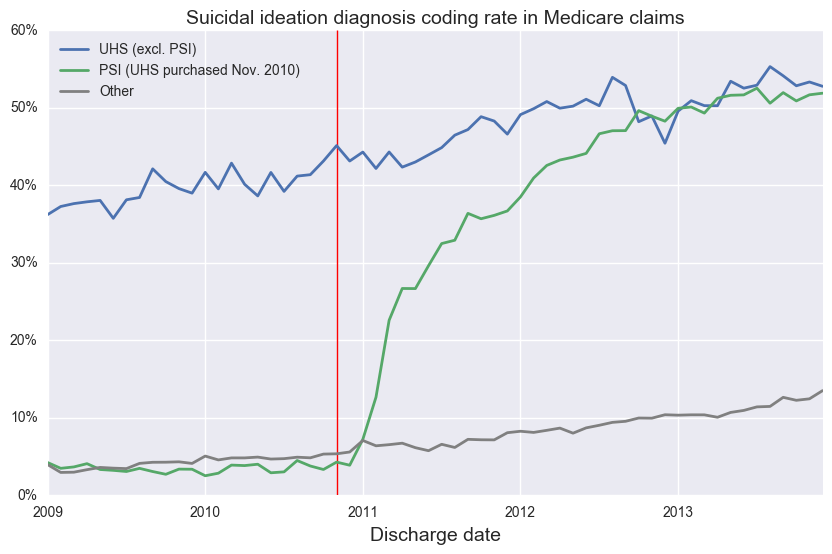

In [53]:
# Plot UHS and PSI
data = discharges[
    discharges["uhs_at_discharge"] |
    discharges["psi_at_discharge"]
].groupby([
    "psi_at_discharge",
]).apply(lambda x: get_si_rate(x, "MS")).T.rename(columns={
    False: "UHS (excl. PSI)",
    True: "PSI (UHS purchased Nov. 2010)"
})
data["Other"] = discharges[
    ~(discharges["uhs_at_discharge"] |
    discharges["psi_at_discharge"])
].pipe(lambda x: get_si_rate(x, "MS"))

ax = data.plot(figsize=(10, 6), lw=2, color=sb.color_palette()[:2] + ["gray"])

# Add line representing PSI acquisition date
ax.vlines(PSI_ACQUISITION_DATE, 0, 0.6, lw=1, color="red")
format_chart(ax)
ax.set_title("Suicidal ideation diagnosis coding rate in Medicare claims", fontsize=14)
pass

Among only the first 10 diagnoses listed, which doesn't substantially alter the trend:

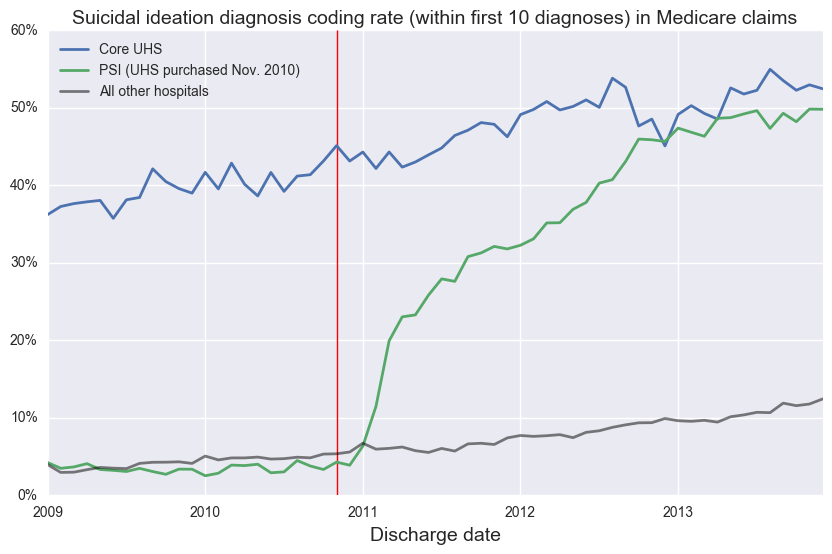

In [54]:
# Plot UHS and PSI
ax = discharges[
    discharges["uhs_at_discharge"] |
    discharges["psi_at_discharge"]
].groupby([
    "psi_at_discharge",
]).apply(lambda x: get_si_rate(x, "MS", "diagnoses_incl_si_10")).T.rename(columns={
    False: "Core UHS",
    True: "PSI (UHS purchased Nov. 2010)"
}).plot(figsize=(10, 6), lw=2)

# Plot all other hospitals
discharges[
    ~(discharges["uhs_at_discharge"] |
    discharges["psi_at_discharge"])
].pipe(lambda x: get_si_rate(x, "MS", "diagnoses_incl_si_10"))\
    .plot(ax=ax, lw=2, alpha=0.5, color="black", label="All other hospitals")

# Add line representing PSI acquisition date
ax.vlines(PSI_ACQUISITION_DATE, 0, 0.6, lw=1, color="red")
format_chart(ax)
ax.set_title("Suicidal ideation diagnosis coding rate (within first 10 diagnoses) in Medicare claims", fontsize=14)
pass

---

# River Point analysis

The analysis below focuses on Medicare claims filed by River Point Behavioral Health facility in Jacksonville, Florida.

In [55]:
river_point = discharges[
    discharges["PROVIDER"] == "104016" # 104016 is River Point's CMS certification number
].copy()

Calcultate length of stay, in days:

In [56]:
river_point["length_of_stay"] = (river_point["discharge_dt"] - river_point["admission_dt"]).dt.days

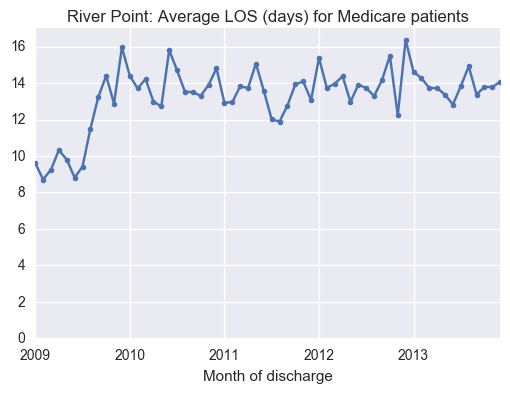

In [57]:
ax = river_point.set_index("discharge_dt")\
    .resample("MS")["length_of_stay"].mean()\
    .plot(marker=".", markersize=8, ylim=(0, None))
ax.set_title("River Point: Average LOS (days) for Medicare patients")
ax.set_xlabel("Month of discharge")
pass

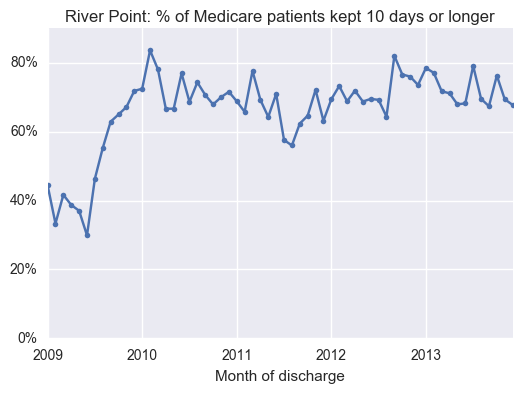

In [58]:
data = river_point.set_index("discharge_dt")\
    .resample("MS")["length_of_stay"].apply(lambda x: (x >= 10).mean())
ax = data.plot(marker="o", markersize=4, ylim=(0, None))
ax.set_title("River Point: % of Medicare patients kept 10 days or longer")
ax.set_xlabel("Month of discharge")
percentify_yaxis(ax)
pass

### Averages by period

The analysis below groups River Point discharges into four categories, based on time period:

- Jan. 2009 - June 2009:  __2009, first half__
- July 2009 - Dec. 2009: __2009, second half__
- Jan. 2010 – Jun. 2010: __2010, first half__
- Jul. 2010 - Dec. 2013: __July 2010–2013__


In [59]:
def label_river_point_period(date):
    if date.date() < datetime.date(2009, 7, 1): return "2009, first half"
    if date.date() < datetime.date(2010, 1, 1): return "2009, second half"
    if date.date() < datetime.date(2010, 7, 1): return "2010, first half"
    return "July 2010–2013"

In [60]:
river_point["period"] = river_point["discharge_dt"].apply(label_river_point_period)

In [61]:
grp = river_point.groupby("period")
pd.DataFrame({
    "average_length_of_stay": grp["length_of_stay"].mean().round(1),
    "proportion_10_days_plus": grp["length_of_stay"].apply(lambda x: (x >= 10).mean()).round(3)
})

,average_length_of_stay,proportion_10_days_plus
period,,
"2009, first half",9.4,0.370
"2009, second half",12.7,0.608
"2010, first half",13.9,0.735
July 2010–2013,13.8,0.701


---

---

---